# Cluster headache simulations: Full model

In [500]:
import numpy as np
from scipy.stats import lognorm, gmean, rv_discrete, norm, stats, beta, truncnorm, expon
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Groups

We'll use stratified sampling, meaning that we will simulate subgroups of CH sufferers with common traits separately. We'll start with four groups defined by episodic vs chronic and treated vs untreated.

In [472]:
# Define the overall population
annual_prevalence = 53/100000 # 53 per 100,000 (95% CI: 26, 95) of adults
world_population = 8_200_000_000
adult_fraction = 0.72
total_ch_sufferers = world_population * adult_fraction * annual_prevalence # Estimated global CH sufferers

# Define the proportions for each group
prop_episodic = 0.80
prop_chronic = 1 - prop_episodic
prop_treated = 0.48
prop_untreated = 1 - prop_treated

# Define the groups
ch_groups = {
    'Episodic Treated': int(total_ch_sufferers * prop_episodic * prop_treated),
    'Episodic Untreated': int(total_ch_sufferers * prop_episodic * prop_untreated),
    'Chronic Treated': int(total_ch_sufferers * prop_chronic * prop_treated),
    'Chronic Untreated': int(total_ch_sufferers * prop_chronic * prop_untreated)
}

# Print group sizes
for group, size in groups.items():
    print(f"{group}: {size:,.0f}")

Episodic Treated: 1,201,582
Episodic Untreated: 1,301,714
Chronic Treated: 300,396
Chronic Untreated: 325,428


## Modeling annual bout frequency for episodic CH sufferers

General idea: For ease of understanding, assume CH sufferers have an integer number of bouts per year. Combine data from papers reporting bout frequency. Use a simple discrete distribution.

In [416]:
data = {
    # Discretized approximation for a distribution with mean 1.2, SD 1.1
    'Gaul': {'n': 209, 'dist': {1: 0.6, 2: 0.3, 3: 0.1}},  
    
    # Split "<1/year" between 0 and 1, ">1/year" between 2 and 3
    'Li': {'n': 327, 'dist': {0.5: 0.416, 1: 0.370, 2.5: 0.214}},
    
    # Split "1/1.5-2 years" between 0 and 1
    'Friedman': {'n': 50, 'dist': {0.5: 0.46, 1: 0.54}},

    
    # Split "<1/year" between 0 and 1
    'Ekbom': {'n': 105, 'dist': {0.5: 0.14, 1: 0.40, 2: 0.31, 3: 0.15}},
    
    # Split "1-2/year" evenly between 1 and 2
    'Manzoni': {'n': 161, 'dist': {1: 0.27, 1.5: 0.73}},
    
    # Converted from remission periods to bouts/year, chronic cases removed
    'Sutherland': {'n': 49, 'dist': {
        0.5: 0.512+0.174,  # 1-5 years, adding >5 years for simplicity
        1: 0.140,    # 6-12 months
        2: 0.174     # 3-6 months
    }},
    
    # Estimated from remission periods, splitting some categories
    'Kudrow': {'n': 428, 'dist': {0.5: 0.19, 1: 0.67, 2.5: 0.14}}
    
}

# Combine distributions
combined_dist = {}
total_n = sum(study['n'] for study in data.values())

for study in data.values():
    weight = study['n'] / total_n
    for bouts, prob in study['dist'].items():
        combined_dist[bouts] = combined_dist.get(bouts, 0) + prob * weight

# Normalize the combined distribution
total_prob = sum(combined_dist.values())
combined_dist = {k: v/total_prob for k, v in combined_dist.items()}

# Create custom discrete distribution
bouts_per_year = rv_discrete(values=(list(combined_dist.keys()), list(combined_dist.values())))

# Print statistics from distribution
mean_dist = bouts_per_year.mean()
median_dist = bouts_per_year.median()
print("Distribution statistics:")
print(f"Mean: {mean_dist:.4f}")
print(f"Median: {median_dist:.4f}")
print("Distribution:")
for value, prob in sorted(combined_dist.items()):
    print(f"Percentage {value} bouts/year: {prob*100:.1f}%")
    
# Print statistics from samples
samples = bouts_per_year.rvs(size=100000)
mean_samples = np.mean(samples)
median_samples = np.median(samples)
print("\nSample statistics:")
print(f"Mean: {mean_samples:.4f}")
print(f"Median: {median_samples:.4f}")
for i in range(4):
    print(f"Percentage {i} bouts/year: {(samples == i).mean()*100:.1f}%")

Distribution statistics:
Mean: 1.2155
Median: 1.0000
Distribution:
Percentage 0.5 bouts/year: 21.7%
Percentage 1 bouts/year: 49.1%
Percentage 1.5 bouts/year: 8.8%
Percentage 2 bouts/year: 7.8%
Percentage 2.5 bouts/year: 9.8%
Percentage 3 bouts/year: 2.8%

Sample statistics:
Mean: 1.2141
Median: 1.0000
Percentage 0 bouts/year: 0.0%
Percentage 1 bouts/year: 49.1%
Percentage 2 bouts/year: 7.8%
Percentage 3 bouts/year: 2.7%


## Modeling bout duration for episodic CH sufferers

General idea: Fit a lognormal distribution based on the datapoints I gathered from 8 papers.

/usr/local/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


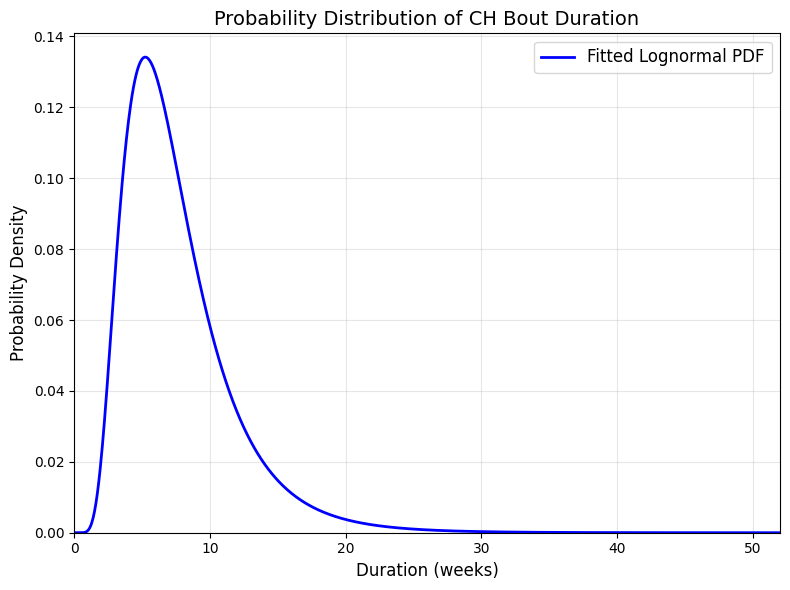

10th percentile: 3.55 weeks
25th percentile: 4.81 weeks
50th percentile: 6.74 weeks
75th percentile: 9.44 weeks
90th percentile: 12.79 weeks
99th percentile: 21.56 weeks


In [417]:
data = []
sample_sizes = []

# Gaul et al. (2012)
data.append(8.5)
sample_sizes.append(209)

# Li et al. (2022)
total_li = 327
data.extend([1, gmean([2, 4]), gmean([4, 8]), 8])
sample_sizes.extend([int(0.104 * total_li), int(0.235 * total_li), int(0.502 * total_li), int(0.131 * total_li)])

# Friedman & Mikropoulos (1958)
data.append(gmean([6, 8]))
sample_sizes.append(50)

# Ekbom (1970)
data.append(gmean([4, 12]))
sample_sizes.append(105)

# Lance & Anthony (1971)
data.append(gmean([2, 12]))
sample_sizes.append(60)

# Sutherland & Eadie (1972)
total_sutherland = 58
data.extend([gmean([0, 4]), gmean([5, 13]), gmean([14, 26]), gmean([27, 52])])
sample_sizes.extend([int(0.23 * total_sutherland), int(0.45 * total_sutherland), 
                     int(0.19 * total_sutherland), int(0.04 * total_sutherland)])

# Rozen & Fishman (2012)
data.append(10.3)
sample_sizes.append(101)

# Manzoni et al. (1983)
data.append(gmean([4, 8]))
sample_sizes.append(161)

# Convert to numpy arrays
data = np.array(data)
sample_sizes = np.array(sample_sizes)

# Use sample sizes as weights
weights = sample_sizes / np.sum(sample_sizes)

# Fitting the lognormal distribution
def neg_log_likelihood(params):
    mu, sigma = params
    return -np.sum(weights * lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))

initial_params = [np.log(np.average(data, weights=weights)), 0.5]
result = minimize(neg_log_likelihood, initial_params, method='Nelder-Mead')
optimal_mu, optimal_sigma = result.x

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 52, 1000)
plt.plot(x, lognorm.pdf(x, s=optimal_sigma, scale=np.exp(optimal_mu)), 'b-', lw=2, 
         label='Fitted Lognormal PDF')

plt.title('Probability Distribution of CH Bout Duration', fontsize=14)
plt.xlabel('Duration (weeks)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 52)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
values = lognorm.ppf(np.array(percentiles) / 100, s=optimal_sigma, scale=np.exp(optimal_mu))
for p, v in zip(percentiles, values):
    print(f"{p}th percentile: {v:.2f} weeks")

## Modeling attacks per day for both episodic and chronic CH sufferers

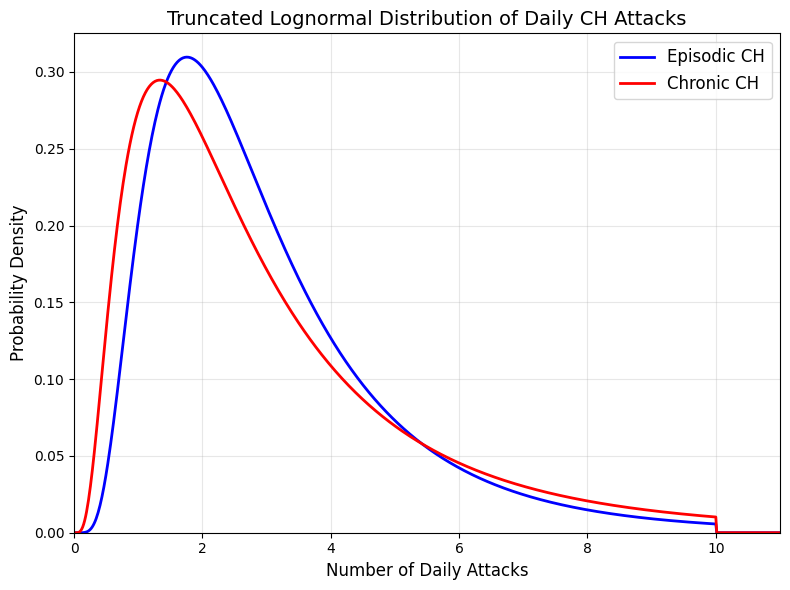


Episodic CH:
Truncated Mean: 3.10
Median: 2.57
Parameters - mu: 0.9426, sigma: 0.6146

Chronic CH:
Truncated Mean: 3.30
Median: 2.44
Parameters - mu: 0.8927, sigma: 0.7761

Episodic CH Percentiles:
10th percentile: 1.17 attacks/day
25th percentile: 1.70 attacks/day
50th percentile: 2.57 attacks/day
75th percentile: 3.88 attacks/day
90th percentile: 5.64 attacks/day
99th percentile: 10.00 attacks/day

Chronic CH Percentiles:
10th percentile: 0.90 attacks/day
25th percentile: 1.45 attacks/day
50th percentile: 2.44 attacks/day
75th percentile: 4.12 attacks/day
90th percentile: 6.60 attacks/day
99th percentile: 10.00 attacks/day


In [418]:
def fit_lognormal(mean, std):
    """
    Fit a lognormal distribution given mean and standard deviation.
    Returns the mu and sigma parameters of the lognormal distribution.
    """
    variance = std**2
    mu = np.log(mean**2 / np.sqrt(variance + mean**2))
    sigma = np.sqrt(np.log(1 + variance / mean**2))
    return mu, sigma

def truncated_lognorm_pdf(x, mu, sigma, upper_bound):
    """
    Calculate the PDF of a truncated lognormal distribution.
    """
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    cdf_upper = lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))
    return np.where(x <= upper_bound, pdf / cdf_upper, 0)

# Gaul et al. (2012) data
episodic_mean, episodic_std = 3.1, 2.1
chronic_mean, chronic_std = 3.3, 3.0
max_daily_ch = 10

# Fit lognormal distributions
episodic_mu, episodic_sigma = fit_lognormal(episodic_mean, episodic_std)
chronic_mu, chronic_sigma = fit_lognormal(chronic_mean, chronic_std)

# Function to calculate mean of truncated distribution
def truncated_mean(mu, sigma, upper_bound):
    return np.exp(mu + sigma**2/2) * (lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu)) - 
                                      lognorm.cdf(0, s=sigma, scale=np.exp(mu))) / \
           lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 15, 1000)
plt.plot(x, truncated_lognorm_pdf(x, episodic_mu, episodic_sigma, max_daily_ch), 'b-', lw=2, 
         label='Episodic CH')
plt.plot(x, truncated_lognorm_pdf(x, chronic_mu, chronic_sigma, max_daily_ch), 'r-', lw=2, 
         label='Chronic CH')

plt.title('Truncated Lognormal Distribution of Daily CH Attacks', fontsize=14)
plt.xlabel('Number of Daily Attacks', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, max_daily_ch+1)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Print summary statistics and probabilities
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH:")
    print(f"Truncated Mean: {truncated_mean(mu, sigma, max_daily_ch):.2f}")
    print(f"Median: {lognorm.median(s=sigma, scale=np.exp(mu)):.2f}")
    print(f"Parameters - mu: {mu:.4f}, sigma: {sigma:.4f}")

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH Percentiles:")
    values = np.minimum(lognorm.ppf(np.array(percentiles) / 100, s=sigma, scale=np.exp(mu)), max_daily_ch)
    for p, v in zip(percentiles, values):
        print(f"{p}th percentile: {v:.2f} attacks/day")

## Simulating total CH annual frequency

Mean annual attacks: 243 (0.7 per day)
Median annual attacks: 164 (0.4 per day)
SD: 222
10th percentile: 53 (0.1 per day)
20th percentile: 76 (0.2 per day)
25th percentile: 87 (0.2 per day)
30th percentile: 100 (0.3 per day)
40th percentile: 128 (0.4 per day)
50th percentile: 164 (0.4 per day)
60th percentile: 211 (0.6 per day)
70th percentile: 276 (0.8 per day)
75th percentile: 320 (0.9 per day)
80th percentile: 377 (1.0 per day)
90th percentile: 556 (1.5 per day)
95th percentile: 755 (2.1 per day)
98th percentile: 947 (2.6 per day)


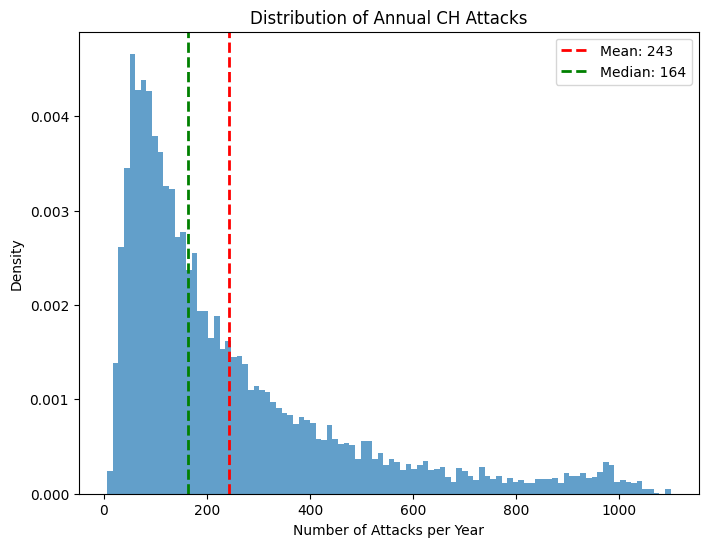

In [419]:
def generate_chronic_active_days():
    while True:
        # Generate total days in attack periods
        active_days = int(lognorm.rvs(s=.5, scale=np.exp(np.log(200))))
        
        # Ensure active_days is never over 365
        active_days = min(active_days, 365)
        
        return active_days

def simulate_annual_attacks(n_simulations=10000):
    annual_attacks = []
    
    for _ in range(n_simulations):
        # Determine if episodic or chronic
        is_episodic = np.random.random() < 0.80
        #is_episodic = False
        
        if is_episodic:
            # Generate number of bouts from our custom discrete distribution
            n_bouts = bouts_per_year.rvs()
            
            # Generate bout durations
            bout_durations = lognorm.rvs(s=optimal_sigma, scale=np.exp(optimal_mu), size=int(np.ceil(n_bouts)))
            
            # If n_bouts is not an integer, adjust the last bout duration
            if n_bouts != int(n_bouts):
                bout_durations[-1] *= (n_bouts - int(n_bouts))
            
            # Daily attacks for each bout
            daily_attacks = []
            for duration in bout_durations:
                days = max(1, int(duration * 7))  # Convert weeks to days, ensure at least 1 day
                attacks = np.minimum(lognorm.rvs(s=episodic_sigma, scale=np.exp(episodic_mu), size=days), max_daily_ch)
                daily_attacks.extend(np.floor(attacks))
            
            total_attacks = sum(daily_attacks)
        
        else:  # Chronic
            active_days = generate_chronic_active_days()
            daily_attacks = np.minimum(lognorm.rvs(s=chronic_sigma, scale=np.exp(chronic_mu), size=active_days), max_daily_ch)
            total_attacks = sum(np.floor(daily_attacks))
        
        annual_attacks.append(total_attacks)
    
    return np.array(annual_attacks)

# Run the simulation
annual_attack_distribution = simulate_annual_attacks()

# Calculate statistics
mean_attacks = np.mean(annual_attack_distribution)
median_attacks = np.median(annual_attack_distribution)
std_attacks = np.std(annual_attack_distribution)

percentile_values = [10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 98]
percentiles = np.percentile(annual_attack_distribution, percentile_values)

# Print results
print(f"Mean annual attacks: {mean_attacks:.0f} ({mean_attacks/365:.1f} per day)")
print(f"Median annual attacks: {median_attacks:.0f} ({median_attacks/365:.1f} per day)")
print(f"SD: {std_attacks:.0f}")
for i, percentile in enumerate(percentiles):
    print(f"{percentile_values[i]}th percentile: {percentile:.0f} ({percentile/365:.1f} per day)")

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(annual_attack_distribution, bins=100, density=True, alpha=0.7)
plt.title("Distribution of Annual CH Attacks")
plt.xlabel("Number of Attacks per Year")
plt.ylabel("Density")
plt.axvline(mean_attacks, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_attacks:.0f}')
plt.axvline(median_attacks, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_attacks:.0f}')
plt.legend()
plt.show()

### Sampling to compare with survey

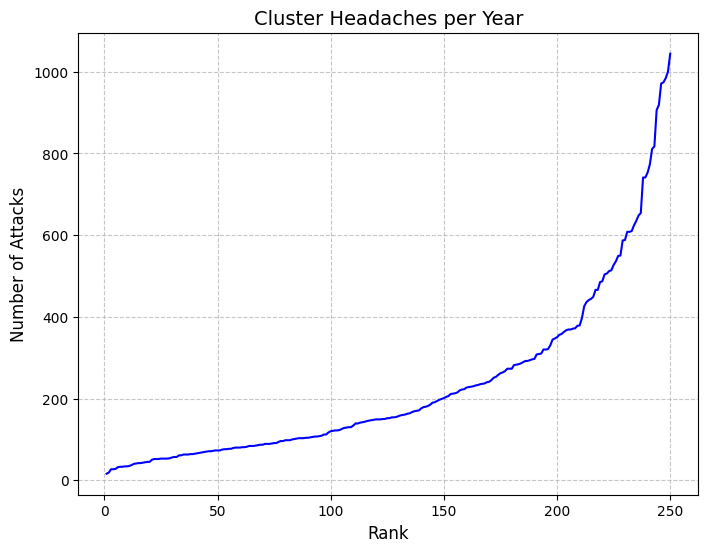

Minimum annual attacks (non-zero): 16
Maximum annual attacks: 1044
Median annual attacks (non-zero): 152


In [420]:
# Sample 250 values from the distribution
sample_size = 250
sampled_attacks = np.random.choice(annual_attack_distribution, size=sample_size, replace=False)

# Sort in ascending order
sorted_attacks = np.sort(sampled_attacks)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(sorted_attacks) + 1), sorted_attacks, color='blue')
plt.title('Cluster Headaches per Year', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print some statistics about the sampled data
print(f"Minimum annual attacks (non-zero): {sorted_attacks[0]:.0f}")
print(f"Maximum annual attacks: {sorted_attacks[-1]:.0f}")
print(f"Median annual attacks (non-zero): {np.median(sorted_attacks):.0f}")


Summary for Episodic, Untreated:
Mean: 58.61
Median: 54.00
Std Dev: 24.89
10th percentile: 32.00
90th percentile: 91.00

Summary for Chronic, Untreated:
Mean: 65.05
Median: 60.00
Std Dev: 27.47
10th percentile: 36.00
90th percentile: 100.10

Summary for Episodic, Treated:
Mean: 41.01
Median: 38.00
Std Dev: 17.27
10th percentile: 22.00
90th percentile: 64.00

Summary for Chronic, Treated:
Mean: 45.34
Median: 42.00
Std Dev: 19.14
10th percentile: 25.00
90th percentile: 70.00


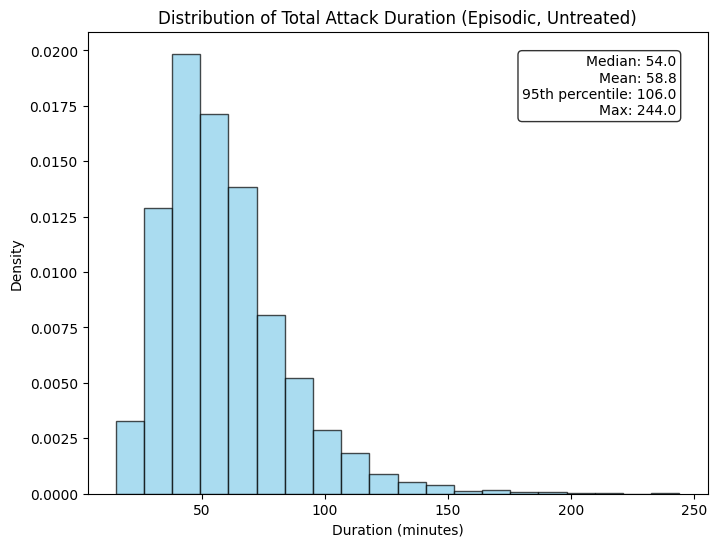

Minimum duration: 15.0 minutes
Median duration: 54.0 minutes
Mean duration: 58.8 minutes
95th percentile duration: 106.0 minutes
Maximum duration: 244.0 minutes


In [503]:
def generate_attack_duration(is_chronic=False, treated=False, mu=4.0, sigma=0.4):
    # Adjust parameters based on chronic/episodic status
    if is_chronic:
        mu += 0.1  # Slightly longer attacks for chronic sufferers
        
    duration = lognorm.rvs(s=sigma, scale=np.exp(mu))
    
    if treated:
        #treatment_effect = np.random.normal(0.7, 0.05)  # Random effect centered at 0.7
        treatment_effect = 0.7 # Constant 30% reduction for treated attacks
        duration *= treatment_effect
    
    duration = int(np.clip(duration, 15, 360))
    return duration

# Calculate and print summary statistics
def print_summary_stats(is_chronic, treated, n=10000):
    durations = [generate_attack_duration(is_chronic, treated) for _ in range(n)]
    print(f"\nSummary for {'Chronic' if is_chronic else 'Episodic'}, {'Treated' if treated else 'Untreated'}:")
    print(f"Mean: {np.mean(durations):.2f}")
    print(f"Median: {np.median(durations):.2f}")
    print(f"Std Dev: {np.std(durations):.2f}")
    print(f"10th percentile: {np.percentile(durations, 10):.2f}")
    print(f"90th percentile: {np.percentile(durations, 90):.2f}")

print_summary_stats(is_chronic=False, treated=False)
print_summary_stats(is_chronic=True, treated=False)
print_summary_stats(is_chronic=False, treated=True)
print_summary_stats(is_chronic=True, treated=True)

# Generate sample data
samples = [generate_attack_duration(is_chronic=False, treated=False) for _ in range(10000)]

# Create plot
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Attack Duration (Episodic, Untreated)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')

# Add some statistics to the plot
minimum_duration = np.min(samples)
median_duration = np.median(samples)
mean_duration = np.mean(samples)
percentile_95 = np.percentile(samples, 95)
max_duration = max(samples)

stats_text = f'Median: {median_duration:.1f}\nMean: {mean_duration:.1f}\n95th percentile: {percentile_95:.1f}\nMax: {max_duration:.1f}'
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Print statistics
print(f"Minimum duration: {minimum_duration:.1f} minutes")
print(f"Median duration: {median_duration:.1f} minutes")
print(f"Mean duration: {mean_duration:.1f} minutes")
print(f"95th percentile duration: {percentile_95:.1f} minutes")
print(f"Maximum duration: {max_duration:.1f} minutes")

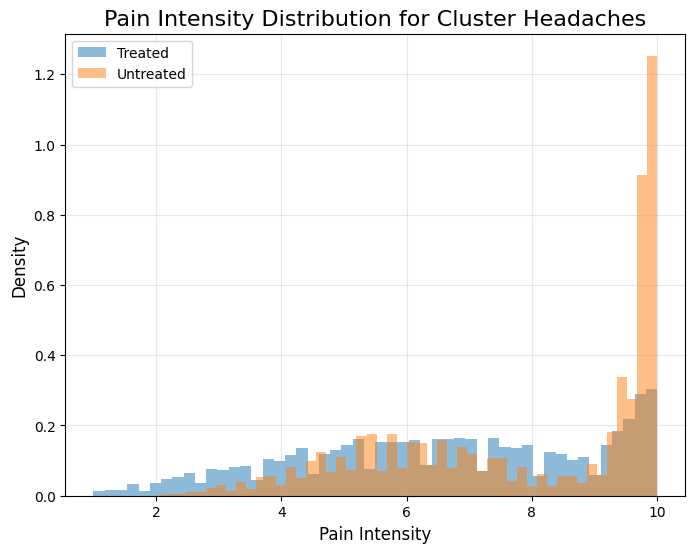


Treated:
Mean: 6.57
Median: 6.60
Percentage of 10/10 pain: 1.94%
25th percentile: 4.80
50th percentile: 6.60
75th percentile: 8.60
90th percentile: 9.70

Untreated:
Mean: 7.83
Median: 8.80
Percentage of 10/10 pain: 7.80%
25th percentile: 5.90
50th percentile: 8.80
75th percentile: 9.80
90th percentile: 9.90

Sample generated pain intensities:
Treated: [8.8, 7.0, 8.9, 8.1, 9.4, 4.1, 6.2, 1.0, 9.0, 6.2]
Untreated: [9.9, 4.1, 6.1, 9.9, 6.8, 9.6, 9.6, 9.9, 9.7, 6.5]


In [501]:
def get_truncated_normal(mean=5, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def reversed_exponential(scale):
    return 10 - expon.rvs(scale=scale)

def generate_pain_intensity(treated=False, decimals=1):
    if treated:
        # For treated patients:
        # Mix of three distributions
        choice = np.random.choice(3, p=[0.30, 0.50, 0.20])
        if choice == 0:
            # Mild to moderate pain
            pain = get_truncated_normal(mean=4, sd=1.5, low=1, upp=7).rvs()
        elif choice == 1:
            # Moderate to severe pain
            pain = get_truncated_normal(mean=7, sd=1.5, low=4, upp=10).rvs()
        else:
            # Very severe pain
            pain = reversed_exponential(scale=0.5)
    else:
        # For untreated patients:
        # Mix of two distributions, skewed towards severe pain
        choice = np.random.choice(2, p=[0.50, 0.50])
        if choice == 0:
            # Moderate to severe pain
            pain = get_truncated_normal(mean=6, sd=1.5, low=2, upp=10).rvs()
        else:
            # Very severe pain
            pain = reversed_exponential(scale=0.3)

    return round(min(max(pain, 0), 10), decimals)

# Generate samples
n_samples = 10000
treated_samples = [generate_pain_intensity(treated=True) for _ in range(n_samples)]
untreated_samples = [generate_pain_intensity(treated=False) for _ in range(n_samples)]

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(treated_samples, bins=50, alpha=0.5, label='Treated', density=True)
plt.hist(untreated_samples, bins=50, alpha=0.5, label='Untreated', density=True)
plt.title('Pain Intensity Distribution for Cluster Headaches', fontsize=16)
plt.xlabel('Pain Intensity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
for name, samples in [("Treated", treated_samples), ("Untreated", untreated_samples)]:
    print(f"\n{name}:")
    print(f"Mean: {np.mean(samples):.2f}")
    print(f"Median: {np.median(samples):.2f}")
    print(f"Percentage of 10/10 pain: {(np.array(samples) == 10).mean():.2%}")
    for p in [25, 50, 75, 90]:
        print(f"{p}th percentile: {np.percentile(samples, p):.2f}")

# Test the generation
print("\nSample generated pain intensities:")
print("Treated:", [generate_pain_intensity(treated=True) for _ in range(10)])
print("Untreated:", [generate_pain_intensity(treated=False) for _ in range(10)])

In [504]:
class Patient:
    def __init__(self, is_chronic, is_treated):
        self.is_chronic = is_chronic
        self.is_treated = is_treated
        self.generate_profile()
        self.attacks = []
        
    def generate_profile(self):
        if self.is_chronic:
            self.generate_chronic_profile()
        else:
            self.generate_episodic_profile()

    def generate_chronic_profile(self):
        self.active_days = generate_active_days_chronic()
        self.attacks_per_day = generate_attacks_per_day(is_chronic=True)

    def generate_episodic_profile(self):
        self.annual_bouts = generate_annual_bouts()
        self.bout_duration = generate_bout_duration()
        self.attacks_per_day = generate_attacks_per_day(is_chronic=False)

    def generate_year_of_attacks(self):
        # Implement logic to generate a full year of attacks
        # This should use the profile characteristics and other functions
        # like generate_pain_intensity and generate_attack_duration
        pass

    def calculate_annual_burden(self):
        # Implement logic to calculate the annual burden based on attacks
        pass